In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/results-summary-081424/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id", "comments_n"]].dropna()
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")
# comment_public = comment_public[comment_public["author_name"]!=""]

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

In [3]:
channel_labels_all = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_all

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_all[channel_labels_all[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = {}
        CHANNEL_LABEL_MAP[this_ch]["leaning"] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"]["leaning"] = 1
len(CHANNEL_LABEL_MAP)

1 0 # of channels 149
2 -1 # of channels 276
3 1 # of channels 139


564

In [4]:
these_channels = CHANNEL_LABEL_MAP.keys()
pol_view = view_all[view_all["channel_id"].isin(these_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(these_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(these_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(these_channels)].copy()

In [5]:
from src.utils.network_builder import build_projection, read_network
import networkx as nx 

def get_node_level_EI(g):
    
    node_attrs = nx.get_node_attributes(g, "leaning")
    node_strgs = nx.degree(g, weight="weight")
    edge_attrs = nx.get_edge_attributes(g, "weight")

    ei_df = pd.DataFrame()
    eis = []
    leanings = []
    strengths = []
    for n in g.nodes():
        n_attr = node_attrs[n]
        n_strg = node_strgs[n]
        neighbors = nx.neighbors(g, n)
        if n_strg > 0:
            internal = 0
            external = 0
            for nei in neighbors:
                try:
                    w = edge_attrs[nei, n]
                except:
                    w = edge_attrs[n, nei]
                if node_attrs[nei] == n_attr:
                    internal += w 
                else:
                    external += w
            ei = (external - internal) / (external + internal)

            eis.append(ei)
            leanings.append(n_attr)
            strengths.append(n_strg)
    
    ei_df["rate"] = eis
    ei_df["leaning"] = leanings
    ei_df["strength"] = strengths
    return ei_df

In [6]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def compute_assortativity(g):
    node_attrs = nx.get_node_attributes(g, "leaning")
    edge_wghts = nx.get_edge_attributes(g, "weight")
    x = []
    y = []
    w = []
    for n1,n2 in g.edges():
        x.append(node_attrs[n1])
        y.append(node_attrs[n2])
        w.append(edge_wghts[(n1, n2)])
    c = corr(np.array(x), np.array(y), np.array(w))
    return c

def node_counter(g):
    node_attrs = nx.get_node_attributes(g, "leaning")
    counter = {
        1:0,
        0:0,
        -1:0
    }
    for _,a in node_attrs.items():
        counter[a] += 1
    return counter

def edge_type_counter(g, weighted=False):
    counter = {
        (1,1):0,
        (0,0):0,
        (-1,-1):0,
        (1,0):0,
        (1,-1):0,
        (0,-1):0,
    }
    node_attrs = nx.get_node_attributes(g, "leaning")
    edge_wghts = nx.get_edge_attributes(g, "weight")
    for n1,n2 in g.edges():
        a1 = node_attrs[n1]
        a2 = node_attrs[n2]
        w = edge_wghts[(n1, n2)]
        if weighted:
            try:
                counter[(a1,a2)] += w
            except:
                counter[(a2,a1)] += w
        else:
            try:
                counter[(a1,a2)] += 1
            except:
                counter[(a2,a1)] += 1
    return counter

In [7]:
nruns = 200
n_authors = 72
authors_all = list(set(pol_comment_public["author_name"].tolist()))

rates_dfs = []
cs = []
for r in range(nruns):
    print(r)
    these_authors = np.random.choice(authors_all, size=n_authors, replace=False)
    comment_public_sub = pol_comment_public[pol_comment_public["author_name"].isin(these_authors)]

    print("building network...")
    n,e = build_projection(
        df = comment_public_sub,
        node_col = "channel_id",
        feature_col = "author_name",
        density_thres = 0,
        node_label_map = CHANNEL_LABEL_MAP,
        node_labels = ["leaning"],
        print_info = True,
        save_num_idx = True)
    g = read_network(n, e, add_node_attrs=True, add_edge_attrs=True)

    print("computing statistics...")
    rates_dfs.append(get_node_level_EI(g))
    cs.append(compute_assortativity(g))

0
building network...
# of nodes: 52
# of edges: 1326
Graph with 52 nodes and 1326 edges
computing statistics...
1
building network...
# of nodes: 60
# of edges: 1770
Graph with 60 nodes and 1770 edges
computing statistics...
2
building network...
# of nodes: 51
# of edges: 1275
Graph with 51 nodes and 1275 edges
computing statistics...
3
building network...
# of nodes: 45
# of edges: 990
Graph with 45 nodes and 990 edges
computing statistics...
4
building network...
# of nodes: 57
# of edges: 1596
Graph with 57 nodes and 1596 edges
computing statistics...
5
building network...
# of nodes: 53
# of edges: 1378
Graph with 53 nodes and 1378 edges
computing statistics...
6
building network...
# of nodes: 47
# of edges: 1081
Graph with 47 nodes and 1081 edges
computing statistics...
7
building network...
# of nodes: 52
# of edges: 1326
Graph with 52 nodes and 1326 edges
computing statistics...
8
building network...
# of nodes: 62
# of edges: 1891
Graph with 62 nodes and 1891 edges
computing

In [10]:
# compare with boostrapped sample 
engage_type = ["view", "subscribe", "comment", "comment-public"]
rate_data = {}
nruns = 200
for i,this_folder in enumerate(engage_type):
    print(this_folder)
    try:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_EDGE.csv")
    except:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_EDGE.csv")

    edge_df = edge_df[edge_df["weight"]>0]
    if this_folder != "comment-public":
        g = read_network(node_df, edge_df, add_node_attrs=True, add_edge_attrs=True, print_info=False)
        c = compute_assortativity(g)
        rate_data[this_folder] = c 

view
subscribe
comment
comment-public


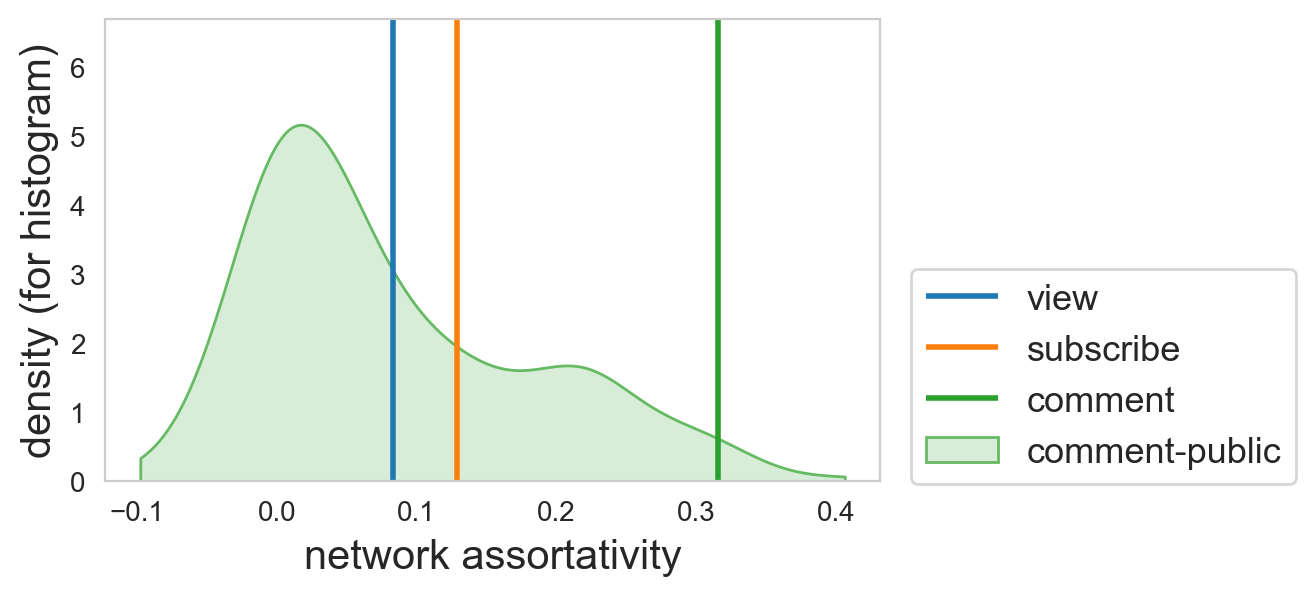

In [12]:
fig,ax = plt.subplots(figsize=(5,3))
import seaborn as sns
# sns.set(style="whitegrid")
sns.set_style("whitegrid", {"axes.grid":False})
ax.vlines(x=rate_data["view"], ymin=0, ymax=18, linewidth=2, color="#1F77B4", label="view")
ax.vlines(x=rate_data["subscribe"], ymin=0, ymax=18, linewidth=2, color="#FF7F0D", label="subscribe")
ax.vlines(x=rate_data["comment"], ymin=0, ymax=18, linewidth=2, color="#2BA02C", label="comment")
sns.kdeplot(cs, cut=0, fill=True, color="#67BA64", label="comment-public")
ax.set_ylim(0,6.7)
ax.legend(bbox_to_anchor=(1.56,0.5), fontsize=13)
ax.set_xlabel("network assortativity", fontsize=15)
ax.set_ylabel("density (for histogram)", fontsize=15)
# plt.tight_layout()
plt.savefig(OUTPATH + "assortativity-with-resample-user-level-before-filtering.pdf", dpi=300, bbox_inches="tight")